In [107]:
import torch
import gpytorch
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance

import matplotlib
import matplotlib.pyplot as plt

from gpytorch.priors import NormalPrior

from tqdm.notebook import tqdm

# Dumbbell

In [114]:
def create_dumbbell(circle_center_x, rec_long_side, rec_short_side):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_radius = distance.euclidean([circle_center_x,0], [rec_long_side/2,rec_short_side/2])
    
    angle = np.arccos((circle_center_x - rec_long_side/2.0)/circle_radius)
    add_angle = 1/(100*circle_radius)
    circle_perimeter = 4 * (np.pi - angle) * circle_radius
    rec_perimeter = 2 * rec_long_side
    total_perimeter = circle_perimeter + rec_perimeter
    
    samples = torch.empty((int(100 * total_perimeter), 2), dtype=torch.float32)
    samples_till_now = 0
    rec_sample = int(rec_perimeter * 50)
    circle_sample = int(circle_perimeter * 50)
    
    for i in range(rec_sample):
        samples[i] = torch.Tensor([-rec_long_side/2 + i/100.0, rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = np.pi - angle
    for j in range(circle_sample):
        new_angle = starting_angle - j*add_angle
        samples[samples_till_now+j] = torch.Tensor([circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    for i in range(rec_sample):
        samples[samples_till_now+i] = torch.Tensor([rec_long_side/2 - i/100.0, -rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = angle
    for j in range(circle_sample):
        new_angle = starting_angle + j*add_angle
        samples[samples_till_now+j] = torch.Tensor([-circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    
    return samples

In [117]:
dumb_sample = create_dumbbell(2.0, 2.0, 1.0)

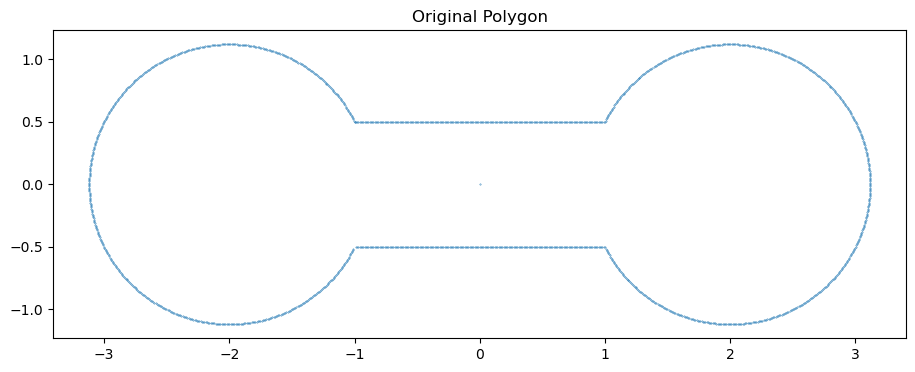

In [118]:
with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(dumb_sample.cpu().numpy()[:, 0], dumb_sample.cpu().numpy()[:, 1], s = 0.1)
        ax.axis('equal')
        ax.set_title(f'Original Polygon')

In [120]:
def create_grid(sampled, eps=0.1, res=0.01):
    dims = len(sampled.shape)
    
    borders = torch.empty((dims, 2), dtype=torch.float32)
    for i in range(dims):
        borders[i, 0] = min(sampled[:,i]) - eps
        borders[i, 1] = max(sampled[:,i]) + eps
        
    grid_sizes = torch.empty(dims, dtype=torch.int32)
    for i in range(dims):
        grid_sizes[i] = (borders[i, 1] - borders[i, 0])/res + 1
        
    grid_points = torch.empty((torch.prod(grid_sizes).int(), 2), dtype=torch.float32)
    if (dims==2):
        for x in range(grid_sizes[0]):
            for y in range(grid_sizes[1]):
                index = (x * grid_sizes[1]) + y
                grid_points[index] = torch.Tensor([borders[0, 0] + x * res, borders[1, 0] + y * res])
    return grid_points, grid_sizes

In [122]:
grid_points, grid_sizes = create_grid(dumb_sample, res=0.01)